Following some of the examples here: https://github.com/pytorch/fairseq/tree/master/examples/roberta

In [136]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from fairseq.data import data_utils
from fairseq.models.roberta import RobertaModel
from fairseq.utils import move_to_cuda
from fairseq.modules import cross_entropy
from scipy.sparse import load_npz
from sklearn.metrics import precision_recall_curve
from tqdm import tqdm

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


roberta = RobertaModel.from_pretrained('/projects/deepgreen/pstjohn/roberta_base_checkpoint/',
                                       checkpoint_file='checkpoint_best.pt')
_ = roberta.eval()  # disable dropout (or leave in train mode to finetune)
_ = roberta.to(device)

In [28]:
roberta.model.args.data = '/projects/deepgreen/pstjohn/uniparc_training_data/split_bin/train_00/'
task = roberta.task.setup_task(roberta.model.args)
task.load_dataset('test')

In [88]:
test_data = task.datasets['test']

In [127]:
from tqdm import tqdm

In [176]:
y_pred = []
y_true = []
total_loss = 0.
total_samples = 0

for batch in tqdm(test_data.batch_by_size(test_data.ordered_indices(), max_sentences=4)):
    
    sample = move_to_cuda(test_data.collater([test_data[i] for i in batch]))
    masked_tokens = sample['target'].ne(roberta.task.source_dictionary.pad_index)

    with torch.no_grad():
        logits = roberta.model(**sample['net_input'], masked_tokens=masked_tokens)[0]
        targets = sample['target'][masked_tokens]
        
        loss = cross_entropy(
            logits.view(-1, logits.size(-1)),
            targets.view(-1),
            reduction='sum',
            ignore_index=roberta.task.source_dictionary.pad_index,
        )
        
        total_loss += float(loss)
        total_samples += targets.numel()
        
        y_pred += [logits.argmax(dim=1).detach().to('cpu').numpy()]
        y_true += [targets.detach().to('cpu').numpy()]    

100%|██████████| 5636/5636 [07:42<00:00, 12.17it/s]


In [ ]:
roberta.model.ign

In [188]:
2** (total_loss / y_true.shape[0] / math.log(2))

7.0076689436516455

In [178]:
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [189]:
(y_true == y_pred).mean()

0.4065122606096606

In [180]:
from sklearn.metrics import confusion_matrix

In [238]:
cm = confusion_matrix(y_true, y_pred) / y_true.shape[0]
print(cm.shape)
cm = cm[3:-1,3:-1]

(24, 24)


In [241]:
labels = [roberta.task.source_dictionary.symbols[i] for i in list(set(y_true))]
labels = labels[3:-1]

Text(24.0, 0.5, 'Predicted')

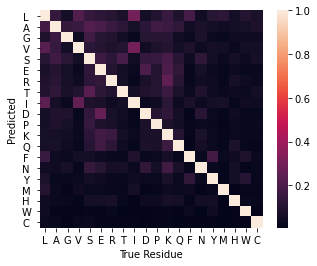

In [266]:
plt.figure(figsize=(5,4))
sns.heatmap(cm / np.diag(cm), xticklabels=labels, yticklabels=labels)
yticks = plt.gca().set_yticklabels(labels, rotation=0, horizontalalignment='center')
plt.gca().get_yaxis().set_tick_params(pad=10)
plt.xlabel('True Residue')
plt.ylabel('Predicted')

In [268]:
np.unravel_index(((cm / np.diag(cm)) - np.diag(np.ones(20))).argmax(), cm.shape)

(3, 8)

In [269]:
labels[3]

'V'

In [270]:
labels[8]

'I'

In [185]:
total_samples

18340316

In [184]:
y_true.shape[0]

2750842

In [43]:
len(test_data)

22542

In [46]:
test_data

In [49]:
batch = test_data[0]

In [ ]:
inputs[0]

In [5]:
# https://www.uniprot.org/uniprot/P14618.fasta
example_sequence = \
"""
MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTGIICTIGPASRSVET
LKEMIKSGMNVARLNFSHGTHEYHAETIKNVRTATESFASDPILYRPVAVALDTKGPEIR
TGLIKGSGTAEVELKKGATLKITLDNAYMEKCDENILWLDYKNICKVVEVGSKIYVDDGL
ISLQVKQKGADFLVTEVENGGSLGSKKGVNLPGAAVDLPAVSEKDIQDLKFGVEQDVDMV
FASFIRKASDVHEVRKVLGEKGKNIKIISKIENHEGVRRFDEILEASDGIMVARGDLGIE
IPAEKVFLAQKMMIGRCNRAGKPVICATQMLESMIKKPRPTRAEGSDVANAVLDGADCIM
LSGETAKGDYPLEAVRMQHLIAREAEAAIYHLQLFEELRRLAPITSDPTEATAVGAVEAS
FKCCSGAIIVLTKSGRSAHQVARYRPRAPIIAVTRNPQTARQAHLYRGIFPVLCKDPVQE
AWAEDVDLRVNFAMNVGKARGFFKKGDVVIVLTGWRPGSGFTNTMRVVPVP
"""

Unlike the roberta example on fairseq, we're not using the GPT-2 byte-pair encoder, so the standard `roberta.encode` and `roberta.decode` methods won't work

In [6]:
def encode(sequence):
    input_sequence = ' '.join(sequence.replace('\n', ''))
    return roberta.task.source_dictionary.encode_line(input_sequence)

def decode(tokens):
    return roberta.task.source_dictionary.string(tokens).replace(' ', '')

In [7]:
tokens = encode(example_sequence)
tokens

tensor([20,  8, 15, 14, 21,  8,  9,  5,  6, 11,  5, 17, 12, 16, 11, 16, 16,  4,
        21,  5,  5, 20,  5, 13, 11, 17,  4,  9, 21, 20, 23, 10,  4, 13, 12, 13,
         8, 14, 14, 12, 11,  5, 10, 18, 11,  6, 12, 12, 23, 11, 12,  6, 14,  5,
         8, 10,  8,  7,  9, 11,  4, 15,  9, 20, 12, 15,  8,  6, 20, 18,  7,  5,
        10,  4, 18, 17,  8, 21,  6, 11, 21,  9, 19, 21,  5,  9, 11, 12, 15, 18,
         7, 10, 11,  5, 11,  9,  8, 17,  5,  8, 13, 14, 12,  4, 19, 10, 14,  7,
         5,  7,  5,  4, 13, 11, 15,  6, 14,  9, 12, 10, 11,  6,  4, 12, 15,  6,
         8,  6, 11,  5,  9,  7,  9,  4, 15, 15,  6,  5, 11,  4, 15, 12, 11,  4,
        13, 18,  5, 19, 20,  9, 15, 23, 13,  9, 18, 12,  4, 22,  4, 13, 19, 15,
        18, 12, 23, 15,  7,  7,  9,  7,  6,  8, 15, 12, 19,  7, 13, 13,  6,  4,
        12,  8,  4, 16,  7, 15, 16, 15,  6,  5, 13, 17,  4,  7, 11,  9,  7,  9,
        18,  6,  6,  8,  4,  6,  8, 15, 15,  6,  7, 18,  4, 14,  6,  5,  5,  7,
        13,  4, 14,  5,  7,  8,  9, 15, 

In [6]:
from textwrap import wrap
decoded_sequence = '\n'.join(wrap(decode(tokens), width=60))
print(decoded_sequence)

MSKPHSEAGTAFIQTQQLHAAMADTFLEHMCRLDIDSPPITARNTGIICTIGPASRSVET
LKEMIKSGMNVARLNFSHGTHEYHAETIKNVRTATESFASDPILYRPVAVALDTKGPEIR
TGLIKGSGTAEVELKKGATLKITLDNAYMEKCDENILWLDYKNICKVVEVGSKIYVDDGL
ISLQVKQKGADFLVTEVENGGSLGSKKGVNLPGAAVDLPAVSEKDIQDLKFGVEQDVDMV
FASFIRKASDVHEVRKVLGEKGKNIKIISKIENHEGVRRFDEILEASDGIMVARGDLGIE
IPAEKVFLAQKMMIGRCNRAGKPVICATQMLESMIKKPRPTRAEGSDVANAVLDGADCIM
LSGETAKGDYPLEAVRMQHLIAREAEAAIYHLQLFEELRRLAPITSDPTEATAVGAVEAS
FKCCSGAIIVLTKSGRSAHQVARYRPRAPIIAVTRNPQTARQAHLYRGIFPVLCKDPVQE
AWAEDVDLRVNFAMNVGKARGFFKKGDVVIVLTGWRPGSGFTNTMRVVPVP


In [7]:
decoded_sequence == example_sequence[1:-1]  # stripping leading and tailing newlines

True

In [10]:
import torch
if torch.cuda.is_available():
    print("Using the GPU")
    roberta.cuda()

with torch.no_grad():
    features = roberta.extract_features(tokens.to(torch.int64))

Using the GPU


In [11]:
features

tensor([[[ 0.1737,  0.0976, -0.0376,  ...,  0.0724, -0.0361,  0.0857],
         [-0.1052,  0.2354, -0.1681,  ..., -0.0185,  0.1915, -0.1655],
         [-0.0129,  0.0157, -0.1035,  ..., -0.0133,  0.1601, -0.0342],
         ...,
         [ 0.0780,  0.2138, -0.0877,  ..., -0.0448,  0.2261,  0.1889],
         [ 0.1001,  0.2172,  0.1093,  ...,  0.0376, -0.0170, -0.0922],
         [ 0.1199,  0.2842,  0.0715,  ...,  0.0889, -0.0753,  0.1925]]],
       device='cuda:0')